# Settings

Change the variables below for different preferences.

In [ ]:
VIDEO_PATHS = [
#  "/content/drive/My Drive/Side Views/FBS-KCl 0.15M/1.avi",
#  "/content/drive/My Drive/Side Views/FBS-KCl 0.15M/5.avi",
#  "/content/drive/My Drive/Side Views/FBS-KCl 0.3M/1.avi",
#  "/content/drive/My Drive/Side Views/FBS-KCl 0.3M/2.avi",
#  "/content/drive/My Drive/Side Views/FBS-KCl 0.3M/3.avi",
#  "/content/drive/My Drive/Side Views/FBS-CaCl2 0.3M/2.avi",
   "/content/drive/MyDrive/30-3 (every 10 sec).avi"]
  #"/content/drive/My Drive/Side Views/NaCl 1M-urea 5g-I/5.avi"]

VIDEO_PATH = VIDEO_PATHS[0]

# Usual
PIXELS_PER_MM = 184.3455
ONE_FRAME_EVERY = 1


COLOR_FACTOR = 1
RELATIVE_DROP_WIDTH = 0.6
WIDTH_FACTOR = 2
RELATIVE_DROP_HORIZ_POSITION = 0.4
HORIZ_POSITION_FACTOR = 1
LOWER_BOUND_RATIO = 0 # minimum height where we allow the drop to be

# Goniometer
#RELATIVE_DROP_AREA = 1/15
#RELATIVE_DROP_WIDTH = 1/2
#RELATIVE_DROP_HORIZ_POSITION = 2/3
#PIXELS_PER_MM = 137.2549
# LOWER_BOUND_RATIO = 0.05 # minimum height where we allow the drop to be


ONE_FRAME_EVERY = 1
CSV_PATH = VIDEO_PATH + "." + str(PIXELS_PER_MM) + ".csv"

# These are ratios related to the total height/width (eg 1 means full height).
# These refer to the POSITION not the SIZE of the droplet.
UPPER_BOUND_RATIO = 0.6 # maximum height where we allow the drop to be
LEFT_BOUND_RATIO = 0 # minimum width where we allow the drop to be
RIGHT_BOUND_RATIO = 1 # maximum width where we allow the drop to be

#sometimes the script had issues in specific frames so we were using a reference
#frame to fix the issues (with shading for example)
TEST_FRAME = 12
RUN_VIDEO = True

# Libraries

In [ ]:
import cv2
import numpy as np
from math import sqrt
from pprint import pprint as pp

import itertools as it

# Colab needs special handing of imshow.
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

#determine the size of the images we want the script to show (600 pix wide)
_cv2_imshow = cv2_imshow
def cv2_imshow(img):
  h,w,_c = img.shape
  w_ = 600
  h_ = int(h / w * w_)
  res = cv2.resize(img, dsize=(w_, h_), interpolation=cv2.INTER_CUBIC)
  _cv2_imshow(res)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the frames

Large videos will take up too much memory so we should be iterating on the frames. For a colab notebook we will just read 100 frames and be done with it.

frame at time(sec):  12.0


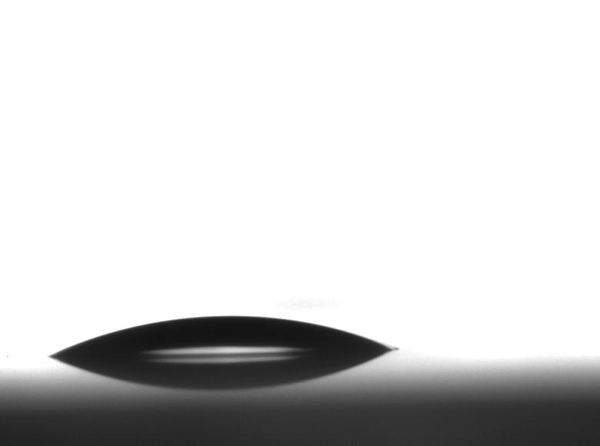

In [ ]:

#read the video
def video_frames(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = []
  #determine fps to know the time point
  fps = float(cap.get(cv2.CAP_PROP_FPS))
  #if the video does not open this variable will be False
  is_open = cap.isOpened()
  #count frames
  frame_num = 0
  while is_open and len(frames) < 1000:
    #cap.read reads frame if there is a frame, if video is over it'll be False
    is_open, frame = cap.read()
    if is_open:
      #when this line is read pass this values to the caller
      #gives each frame and waits
      yield (frame_num/fps,frame)
      frame_num += 1

def nth(iterable, n, default=None):
  "Returns the nth item or a default value"
  return next(it.islice(iterable, n, None), default)

#gets video frames and gives nth video frame which is the test_frame
#(from Settings)
time,frame = nth(video_frames(VIDEO_PATH),TEST_FRAME)
print("frame at time(sec): ", time)
cv2_imshow(frame)

# Contours

These classes are the data abstraction for dealing with contours.

In [ ]:
# finds closed shapes in the image (there are many shapes: for example
#droplet, shadow in the droplet, impurities on background
class Contour(object):
  #gives points of the contour we choose
  def points(self):
    raise NotImplemented

#bounting box - the smallest rectangle that can fit our item (droplet)
  def bbox(self):
    raise NotImplemented

#the distance from one contour to another (for ex. droplet with inner shadow)
#based on the centre of each contour
  def dist(self,other,transform):
    self_pts = np.float32(self.points())
    other_pts = np.float32(other.points())
    ys = np.subtract.outer(self_pts[:,1],other_pts[:,1])
    xs = np.subtract.outer(self_pts[:,0],other_pts[:,0])
    return np.sqrt(np.min(np.sum(transform(np.dstack((xs,ys))) ** 2,axis=2)))

#the centre of the image is the centre of the bounding box
  def center(self):
    (l,r),(t,b) = self.bbox()
    return ((l + r)/2,(t + b)/2)

#the bounding box consists of 4 points. Bounding box image is an image whose
#borders are the 4 points
  def bbox_image(self,on_image=None,image=None):
    (l,r),(t,b) = self.bbox()
    img = self.image if image is None else image
    if on_image is not None:
      img = on_image(img)
    return img[t:b,l:r]

#convert the bounding box to a mask
  def bbox_mask(self,on_mask=None):
    return self.bbox_image(on_image=on_mask,image=self.mask)

#find average colour inside the contour
  def avg_color(self,on_image=None,on_mask=None):
    mask = MaskImage(self.bbox_mask(on_mask=on_mask))
    masked = ColorImage(self.bbox_image(on_image=on_image)).as_greyscale().with_mask(mask)
    return masked.average()

#average colour of the inverted image
  def coavg_color(self):
    return self.avg_color(on_mask=np.invert)

#NOT USED
def approx(c):
  peri = cv2.arcLength(c, True)
  return cv2.approxPolyDP(c, 0.005 * peri, True)

#create a contour consisting of all the contours found in the image,
#using an image and its mask
class ContourForest(Contour):
  @classmethod
  def from_image_mask(cls,image,mask):
    h,w = mask.shape
    white_stripe = np.ones((10,w),dtype=np.uint8) * 255
    mask_with_stripe = np.concatenate((mask, white_stripe))
    cnts,hierarchy = \
      cv2.findContours(mask_with_stripe, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    trees = [ContourTree(c,i,image,mask) for i,c in enumerate(cnts)]
    for t in trees:
      t.initialize(hierarchy[0],trees)

    return cls(sorted(trees,key=lambda x:x.center()[0]),image,mask)

  def __init__(self,trees,image,mask):
    assert type(trees) == list
    self.trees = trees
    self.image = image
    self.mask = mask

  def all_trees(self):
    for t in self.trees:
      yield t
      for c in t.total_children():
        yield c

  def new_trees(self,trees):
    return ContourForest(trees,self.image,self.mask)

#shows contour forest
  def show(self,on_image=None):
    #places all the contours in a list
    cntrs = []
    for c in self.trees:
      cntrs.append(c.contour)
      cntrs += [c0.contour for c0 in c.total_children()]

    img = self.image.copy()
    #draw all the contours (in green) in the image
    img = cv2.drawContours(BaseImage.as_color_raw(img).copy(),cntrs,-1,(0,255,0))
    if on_image is not None:
      img = on_image(img)
    #show the image with the contours
    cv2_imshow(img)

  def outline_mask(self,thickness=20):
    cntrs = []
    for c in self.trees:
      cntrs.append(c.contour)
      cntrs += [c0.contour for c0 in c.total_children()]

    z = np.zeros(self.mask.shape)
    return MaskImage(cv2.drawContours(z,cntrs,-1,255,thickness),self.image)


  def numbers_forest(self,*args,**kw):
    return self.new_trees(list(self._drop_children(
        [c for c in self.trees if c.is_number(*args,**kw)])))

  def _drop_children(self, trees):
    for ci in trees:
      if all((ci not in cj.children for cj in trees)):
        yield ci

  def bbox(self):
    left,right,bot,top = None,None,None,None
    for c in self.trees:
      (l,r),(t,b) = c.bbox()
      left = min(l,left) if left is not None else l
      bot = max(b,bot) if bot is not None else b
      top = min(t,top) if top is not None else t
      right = max(r,right) if right is not None else r

    return ((left,right),(top,bot))

  def area(self):
    return sum((c.area() for c in self.trees))

  def _split_dist(self,trans,thres):
    # We assume the trees are ordered.
    ret = self.new_trees([self.trees[0]])
    rest = self.new_trees([])
    for c in self.trees[1:]:
      if ret.dist(c,trans) < thres:
        ret.append(c)
      else:
        rest.append(c)

    return (ret,rest)

  def __iter__(self):
    return iter(self.trees)

  def dist_groups(self,trans,thres=50):
    rest = self.new_trees(self.trees)
    while rest.trees:
      grp,rest = rest._split_dist(trans,thres)
      yield grp

  def points(self):
    return np.concatenate([t.points() for t in self.trees]).reshape(-1,2)

  def append(self,tree):
    self.trees.append(tree)

  def __len__(self):
    return len(self.trees)

  def __getitem__(self,i):
    if type(i) is int:
      return self.trees[i]
    slice_ = i
    return self.new_trees(self.trees[slice_])

#ContourTree: one contour containing sub-contours (children)
class ContourTree(Contour):
  def __init__(self,contour,id,image,mask,children=None):
    self.contour = contour
    self.image = image
    self.mask = mask
    self.id = id
    self.initialized = children is not None
    self.children = children
    self.__number_param = None

  def clear_children(self):
    return ContourTree(self.contour,self.id,self.image,self.mask,[])

  def new_points(self,points):
    ret = self.__class__(points,id=None,image=self.image,mask=self.mask,children=self.children)
    self.initialized = True
    return ret

  def initialize(self,hierarchy,forest):
    if self.children is not None: return
    self.children = []
    self.next,prev,child,parent = hierarchy[self.id]

    while child > -1:
      forest[child].initialize(hierarchy,forest)
      self.children.append(forest[child])
      child = forest[child].next
      if child == self.id: raise Exception("oos")

#shows the image with the contour in green
  def show(self,on_image=None):
    ContourForest([self],self.image,self.mask).show(on_image)

  def outline_mask(self):
    return ContourForest([self],self.image,self.mask).outline_mask()

  def transform(self,M):
    assert self.children is not None
    M_ = np.concatenate((np.float32(M.T),np.float32([[1,1]]))).T
    (rows,cols,cd) = self.image.shape
    image = cv2.warpAffine(self.image,M_,(cols,rows),flags=cv2.INTER_NEAREST)
    mask = cv2.warpAffine(self.mask,M_,(cols,rows),flags=cv2.INTER_NEAREST)
    return self.__points_transform(M,image,mask)

  def __points_transform(self,M,image,mask):
    contour = np.int32(self.points() @ M.T)
    children = [c.__points_transform(M,image,mask) for c in self.children]
    return self.__class__(contour,self.id,image,mask,children)


  def points(self):
    return self.contour.reshape((-1,2))

#the area of the contour
  def area(self):
    area = cv2.contourArea(self.contour)
    for c in self.children:
      area -= c.area()
    return area

  def arc_length(self):
    arc = cv2.arcLength(self.contour,True)
    for c in self.children:
      arc += c.arc_length()
    return arc

  def total_children(self):
    for c in self.children:
      yield c
      for cc in c.total_children():
        yield cc

  def bbox(self):
    cnt = self.points()
    l = cnt[:,0].min()
    r = cnt[:,0].max()
    t = cnt[:,1].min()
    b = cnt[:,1].max()
    return ((l,r),(t,b))

  def _number_param(self):
    if self.__number_param is not None:
      return self.__number_param

    l = self.arc_length()
    if l == 0:
      self.__number_param = float("inf")
      return self.__number_param

    self.__number_param = self.area()/l
    return self.__number_param

  # 4 and 7 are magic numbers.
  def is_number(self,min_thresh=3.5,max_thresh=7):
    p = self._number_param()
    num_children = [c for c in self.total_children() if c.is_number()]
    a = self.area()
    h,w = self.mask.shape
    ret = min_thresh < p  \
      and p < max_thresh \
      and np.sum(self.coavg_color()) - np.sum(self.avg_color()) > 10 \
      and len(num_children) <= 2
    return ret


# Image abastraction

Some class abstractions for our images. Mostly for showing, converting and threshholding.

In [ ]:
#FOR ALL IMAGES: COLOURED, GRAYSCALE, MASKS
class BaseImage(object):
  #gets an image which may be grayscale or mask and converts it to colour (3-channel)
  @staticmethod
  def as_color_raw(arr_image):
    if len(arr_image.shape) == 2:
      return cv2.cvtColor(arr_image, cv2.COLOR_GRAY2BGR)
    assert len(arr_image.shape) == 3
    assert arr_image.shape[2] == 3
    return arr_image

#can get a b&W image and converts it to 3-channel
  def as_color(self):
    return  ColorImage(BaseImage.as_color_raw(self.image))

#finds the width of the image
  def width(self):
    return self.image.shape[0]

#finds the height of the image
  def height(self):
    return self.image.shape[1]

#converts image to the right type and shows image
  def show(self,on_image=None):
    if on_image is None:
      cv2_imshow(self.as_color().image)
    else:
      cv2_imshow(as_image(self.as_color().image.copy()))

#NOT USED
  def blurred(self,radius=5):
    diam = 2 * radius + 1
    return self.__class__(cv2.GaussianBlur(self.image,(diam,diam),radius/2))

#FOR GRAYSCALE IMAGES AND MASKS - NOT USED U
class GreyBaseImage(BaseImage):
  def average(self):
    return np.average(self.image)

  def normalize(self):
    """Can accept masked"""
    pixvals = self.image
    ret = np.uint8((pixvals - pixvals.min()) / (pixvals.max()-pixvals.min()) * 255)
    return self.__class__(ret,color_image=self.color_image)
#

#Used to find threshold (to create masks and masked images)
class GreyImage(GreyBaseImage):
  def __init__(self,image,color_image=None):
    self.image = image
    self.color_image = color_image

  def as_color(self):
    if self.image.shape[0] * self.image.shape[1] == 0:
      return ColorImage(np.array([[]],dtype=np.uint8,shape=(0,0,3)))
    return ColorImage(cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR))

  def as_greyscale(self):
    return self

  def grads(self):
    d1 = np.diff(self.image,axis=0)
    d2 = np.diff(self.image,axis=0)
    return d1,d2

#otsu algortithm for creating a mask (using threshold)
  def otsu_thresh(self):
    blurred = self.blurred(2)
    ret,img = cv2.threshold(blurred.image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return MaskImage(img,color_image=self.color_image)

#gets a threshold value and gives True or False
  def naive_thresh(self,th=128):
    blurred = self.blurred(2)
    ret,img = cv2.threshold(blurred.image,th,255,cv2.THRESH_BINARY)
    return MaskImage(img,color_image=self.color_image)

#gets the image and finds a small box in the image - finds n neighboring pixels
#finds average and the averge is the threshold for the central pixel
  def adaptive_thresh(self,height_frac=20,method=None):
    blurred = self.blurred(2)
    rad = self.height() // height_frac
    rad = rad if rad % 2 else rad + 1
    method = cv2.ADAPTIVE_THRESH_MEAN_C if method is None or method == "mean" else cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    thresh = cv2.adaptiveThreshold(blurred.image,255,method,cv2.THRESH_BINARY,rad,3)
    return MaskImage(thresh,color_image=self.color_image)

  def with_mask(self,mask):
    assert isinstance(mask,MaskImage)
    return MaskedGreyImage(self.image,mask.image,color_image=self.color_image)

class MaskedGreyImage(GreyBaseImage):
  def __init__(self,image,mask=None,color_image=None):
    if mask is not None:
      self.image = np.ma.array(image,mask=(mask != 0))
    else:
      self.image = image

    self.color_image = color_image
    assert isinstance(self.image,np.ma.MaskedArray),self.image.__class__

  def filled(self,fill=None):
    if fill is None:
      fill = self.image.mean()
    return GreyImage(self.image.filled(fill),color_image=self.color_image)

class ColorImage(BaseImage):
  def __init__(self,image):
    assert len(image.shape) == 3, "Looks like a greyscale or a mask..."
    assert image.shape[2] == 3, "Expected three channels for a color image."
    self.image = image

  def kmeans_masks(self,K=2):
    vectorized = self.image.copy().reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10
    ret,labels,centers=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return MultiMaskImage(res.reshape(self.image.shape),centers,color_image=self)

  def as_color(self):
    return self

  def as_greyscale(self):
    if self.image.shape[0] * self.image.shape[1] == 0:
      arr = np.array([],dtype=np.uint8)
      return GreyImage(arr.reshape((0,0)))
    return GreyImage(cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY),color_image=self)

  def drop_orange(self,K=5):
    # select the least orange mask (it will probably not be a postit)
    (color,mask) = min(self.kmeans_masks(K),key = lambda x: x[0][2])
    norm = self.as_greyscale().with_mask(mask).normalize()
    return norm.filled(0)

  def object_mask(self):
    return self.drop_orange().adaptive_thresh()

  def contour_forest(self):
    return ContourForest.from_image_mask(self.image,self.object_mask().image)

class MultiMaskImage(BaseImage):
  def __init__(self,image,centers,color_image=None):
    self.image = image
    self.centers = centers
    self.color_image = color_image

  def keys(self):
    return list(self.centers)

  def __getitem__(self,color_center):
    if color_center not in self.centers:
      raise IndexError("Center not in masks. Use .keys()")

    mask_3channel = self.image != color_center
    mask = np.min(mask_3channel,axis=2) # Color comparison yields 3 bools. They all need to be True.
    return MaskImage(mask)

  def __iter__(self):
    for c in self.centers:
      yield (c,self[c])


class MaskImage(GreyImage):
  """A mask image is a binary color image.

  For convenience we will be using uint8 though"""

  def __init__(self,mask_image,color_image=None):
    self.color_image = color_image
    self.image = mask_image

  def as_greyscale(self):
    return GreyImage(self.image,color_image=self.color_image)

  def blurred(self):
    return GreyImage(super().blurred().image,color_image=self.color_image)

  def apply_mask(self,img,fill):
    arr = np.ma.array(img,mask=(mask != 0))
    if fill is None:
      fill = np.mean(arr,axis=(0,1))
    return img.__class__(arr.filled(fill),color_image=self.color_image)

  def contour_forest(self):
    return ContourForest.from_image_mask(self.color_image.image,self.image)

  def invert(self):
    return MaskImage(np.invert(self.image),color_image=self.color_image)

# Circle

From 3 points find the circle

In [ ]:
def find_circle(p1, p2, p3):
  x3, y3 = p3
  x2, y2 = p2
  x1, y1 = p1
  x12 = x1 - x2;
  x13 = x1 - x3;

  y12 = y1 - y2;
  y13 = y1 - y3;

  y31 = y3 - y1;
  y21 = y2 - y1;

  x31 = x3 - x1;
  x21 = x2 - x1;

  # x1^2 - x3^2
  sx13 = pow(x1, 2) - pow(x3, 2);

  # y1^2 - y3^2
  sy13 = pow(y1, 2) - pow(y3, 2);

  sx21 = pow(x2, 2) - pow(x1, 2);
  sy21 = pow(y2, 2) - pow(y1, 2);

  f = (((sx13) * (x12) + (sy13) *
        (x12) + (sx21) * (x13) +
        (sy21) * (x13)) // (2 *
        ((y31) * (x12) - (y21) * (x13))));

  g = (((sx13) * (y12) + (sy13) * (y12) +
        (sx21) * (y13) + (sy21) * (y13)) //
        (2 * ((x31) * (y12) - (x21) * (y13))));

  c = (-pow(x1, 2) - pow(y1, 2) -
      2 * g * x1 - 2 * f * y1);

  # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0
  # where centre is (h = -g, k = -f) and
  # radius r as r^2 = h^2 + k^2 - c
  cx = -g;
  cy = -f;
  sqr_of_r = cx ** 2 + cy ** 2 - c;

  # r is the radius
  r = round(sqrt(sqr_of_r), 5);

  return (cx,cy), r

# Droplet specific

Here is the code for managing the droplet itself.

In [ ]:
from collections import namedtuple

class DropProperties(object):
  def __init__(self,contour):
    self.contour = contour
    self.area = contour.area()
    self.bbox = contour.bbox()
    (h,w,_b) = contour.image.shape
    self.shape = (w,h)

  def edges(self):
    g1,g2 = ColorImage(self.contour.image).as_greyscale().grads()
    g = (np.float32(g1)/255) **2 + (np.float32(g2)/255) **2
    mask = np.float32(self.contour.outline_mask().image/255)
    return np.sum(mask[1:,:] * g) / np.sum(g)

  def dimensions(self):
    # The dimensions
    cntr = self.contour
    w,h = self.shape
    (l,r),(b,t) = self.bbox
    area = self.area
    col_ = np.min(cntr.avg_color()) / 256
    oriz_pos_ = (l + r)/(2 * w) - RELATIVE_DROP_HORIZ_POSITION
    width_ = (r - l)/w - RELATIVE_DROP_WIDTH
    Dimensions = namedtuple("Dimensions", ["color", "relative_horiz_pos","relative_width"])
    return Dimensions(col_,oriz_pos_,width_)

  def disqualified(self):
    w,h = self.shape
    (l,r),(b,t) = self.bbox
    area = self.area
    width_ratio = (r - l) / w
    #if width_ratio < .2 or width_ratio > .7:
    #  return True

    if self.contour.points().shape[0] < 10:
      return True

    #if t <= (1 - UPPER_BOUND_RATIO) * h or \
    #    b >= (1 - LOWER_BOUND_RATIO) * h or \
    #    l <= LEFT_BOUND_RATIO * w or \
    #    r >= RIGHT_BOUND_RATIO * w:
    #  return True
    return False

  def as_float(self):
    if self.disqualified():
      return float('inf')
    dim = self.dimensions()
    return COLOR_FACTOR * dim.color ** 2 \
      + HORIZ_POSITION_FACTOR * dim.relative_horiz_pos ** 2 \
      + WIDTH_FACTOR * dim.relative_width ** 2

Dimensions(color=0.1644457885364422, relative_horiz_pos=-0.027564102564102577, relative_width=-0.014102564102564052)


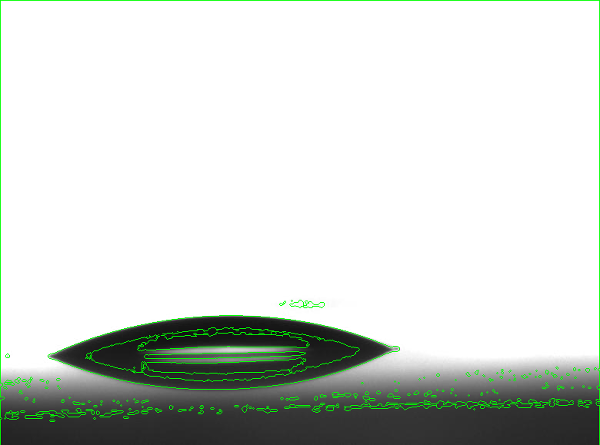

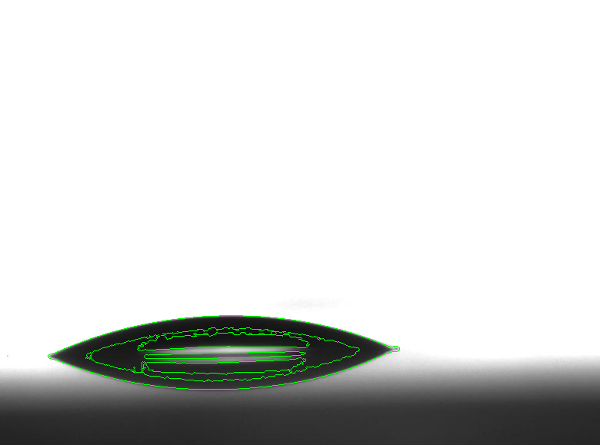

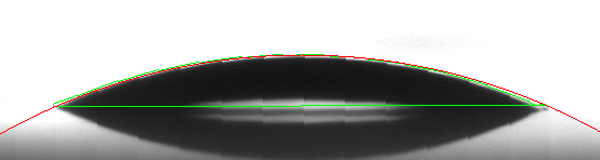

{'contact_angle(degrees)': 23.777316079255957,
 'height(mm)': 0.2603806439538801,
 'height_left(mm)': 0.2603806439538801,
 'height_right(mm)': 0.2603806439538801,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'volume_left(uL)': 0.71358858325118,
 'volume_right(uL)': 0.62140063478536,
 'volume_sph_cap': 0.6348957534451941}


In [ ]:
import typing

#define what a droplet is
class Droplet(object):
  def __init__(self,frame,pix_per_mm=PIXELS_PER_MM,ang_degrees=None):
    self.pix_size = 1/pix_per_mm
    frame = self.__drop_black_rows(frame)
    image = ColorImage(frame)
    # self.forest = image.as_greyscale().adaptive_thresh(height_frac=15).contour_forest()
    self.forest = self.__make_contour_forest(image)
    self.raw_contour = self.__droplet_contour(self.forest)
    self.contour = self.__straight_contour(self.raw_contour,ang_degrees)

  def __make_contour_forest(self, image:ColorImage) -> ContourForest:
    return image.as_greyscale().adaptive_thresh(method="guassian").contour_forest()

  def __droplet_contour(self,contour_forest: ContourForest) -> ContourTree:
    """Choose the contour."""
    trees = [t for t in self.forest.all_trees() if t.points().shape[0] > 300]
    return min(trees,key=lambda x: DropProperties(x).as_float())

  def __straight_contour(self,contour,ang_degrees=None):
    """
    Cut the contour of the droplet in half.
    """
    pts = contour.points()
    amin = pts.argmin(axis=0)[0]
    amax = pts.argmax(axis=0)[0]
    beg = min(amin,amax)
    end = max(amin,amax)
    assert (beg,end) != (0,len(pts))
    assert beg != end, len(pts)
    side1 = pts[beg:end]
    side2 = np.concatenate((pts[end:],pts[:beg]))
    side = side1
    if np.min(side2[:,1]) < np.min(side1[:,1]):
      side = side2

    if ang_degrees is None:
      p_min = pts[beg]
      p_max = pts[end]
      p = np.abs(p_max - p_min)
      hyp = np.sqrt(np.sum(np.square(p)))
      cos_v, sin_v = p[0]/hyp, p[1]/hyp
    else:
      cos_v,sin_v = np.cos(ang_degrees * np.pi / 180), np.sin(ang_degrees * np.pi / 180)

    self.rotate_angle = np.arccos(cos_v)*180 / np.pi

    rot_mat = np.matrix([[cos_v, -sin_v], [sin_v, cos_v]])
    tmp = contour.new_points(side).transform(rot_mat)
    tmp.children = []
    return tmp

  def __drop_black_rows(self,arr):
    rows = np.nonzero(arr)[0]
    h,w,c = arr.shape
    arr = arr[rows[0]:rows[-1]]
    return arr

  #finds the centre of the droplet base using bounding box
  def origin(self):
    (l,r),(t,b) = self.contour.bbox()
    return np.array([(l + r) // 2, b])

  def halves(self):
    # Translate the so origin is in the middle of the base
    origin = self.origin()
    mid = origin[0]
    pts = self.contour.points() - origin
    pts = np.array(np.multiply(pts, np.array([1,-1])))

    # split to halves
    left_half = np.nonzero(pts[:,0] < 0)[0]
    right_half = np.nonzero(pts[:,0] > 0)[0]
    img = self.contour.image
    mask = self.contour.mask
    def mk_half(pts_,name):
      return HalfDroplet(origin,pts_,self.pix_size,img,mask,name)
    return mk_half(pts[left_half],"left"),mk_half(pts[right_half],"right")

  def radius(self):
    (l,r),(t,b) = self.contour.bbox()
    return (r - l)/2 * self.pix_size

  def pix_height(self):
    origin = self.origin()
    mid = origin[0]
    pts = self.contour.points() - origin
    pts = np.array(np.multiply(pts, np.array([1,-1])))
    right_half_head = np.nonzero(pts[:,0] > 0)[0][0]
    return max(1,pts[right_half_head][1])

  def height(self):
    return self.pix_height() * self.pix_size

  def contact_angle(self):
    return (np.pi - 2 * np.arctan(self.radius() / self.height())) * 180 / np.pi

#uses spherical cap approximation
  def volume_sph_cap(self):
    #radius=wide of the bounding box/2
    r = self.radius()
    h = self.height()
    return 1/6. * np.pi * h * (3 * r ** 2 + h ** 2)

  def show(self,on_image=None,crop=True):
    pts = self.contour.points()
    mins = np.argmin(pts,axis=0)
    amin = mins[0,0]
    tmin = mins[0,1]
    amax = pts.argmax(axis=0)[0,0]
    leftmost = list(pts[amin].flat)
    rightmost = list(pts[amax].flat)
    #top = list(pts[tmin].flat)
    top = self.origin() - np.array([0,self.pix_height()])
    (x,y),radius = find_circle(leftmost,rightmost,top)
    def _on_image(img):
      if on_image is None:
        return img
      return on_image(img)
    def draw_circle(img):
      return cv2.circle(_on_image(img),(x,y), np.uint32(radius),(0,0,255))
    def crop_image(img):
      (l,r),(t,b) = self.contour.bbox()
      MARGIN = 50
      l_ = max(0, l - MARGIN)
      t_ = max(0, t - MARGIN)
      r_ = r + MARGIN
      b_ = b + MARGIN
      return draw_circle(img)[t_:b_,l_:r_]
    if crop:
      on_img = crop_image
    else:
      on_img = draw_circle
    self.contour.show(on_img)

  def report(self):
    return {
      "pix/mm":1./self.pix_size,
      "height(mm)":self.height(),
      "radius(mm)":self.radius(),
      "volume_sph_cap":self.volume_sph_cap(),
      "pix/mm":1./self.pix_size,
      "image_rotation(degrees)":self.rotate_angle,
      "contact_angle(degrees)":self.contact_angle()
    }

class HalfDroplet(object):
  def __init__(self,offset,rel_points,pix_size,image,mask,name):
    self.pix_size = pix_size
    self.offset = offset
    self.rel_points = rel_points
    self.image = image
    self.mask = mask
    self.name = name
    assert len(self.rel_points) > 0, self.rel_points.shape

  def pix_radius(self):
    return np.max(np.abs(self.rel_points[:,0]))
  def pix_height(self):
    return np.max(np.abs(self.rel_points[:,1]))

  def radius(self):
    return self.pix_radius() * self.pix_size

  def height(self):
    return self.pix_height() * self.pix_size

  def pix_volume(self):
    hs = np.abs(np.diff(self.rel_points[:,1]))
    pix_rows1 =  self.rel_points[:-1,0]
    pix_rows2 =  self.rel_points[1:,0]
    conic_vols = hs * (pix_rows1 ** 2 + pix_rows2 ** 2 + pix_rows1 * pix_rows2) / 3 * np.pi
    return np.sum(conic_vols)

  def volume(self,):
    return self.pix_volume() * self.pix_size ** 3

  def show(self,on_image=None):
    pts = np.array(np.multiply(self.rel_points,np.array([1,-1]))) + self.offset
    pts = np.int32(np.append(pts,[self.offset],axis=0))
    ContourTree(pts,None,self.image,self.mask,[]).show(on_image=on_image)

  def report(self):
    return {
      "volume_%s(uL)" % self.name:self.volume(),
      "height_%s(mm)" % self.name:self.height()
    }

droplet = Droplet(frame)
print(DropProperties(droplet.raw_contour).dimensions())
droplet.forest.show()
droplet.raw_contour.show()
droplet.show()
l,r = droplet.halves()
report = droplet.report()
report.update(l.report())
report.update(r.report())

pp(report)

# Reading the video

This creates a csv in the same folder as the video being read. `volume_left` and `volume_right` we mean the entire volume according to the pixels counted in the left hemisphere. Especially near the end this is mostly wrong.

##### VIDEO: /content/drive/MyDrive/30-3 (every 10 sec).avi #####


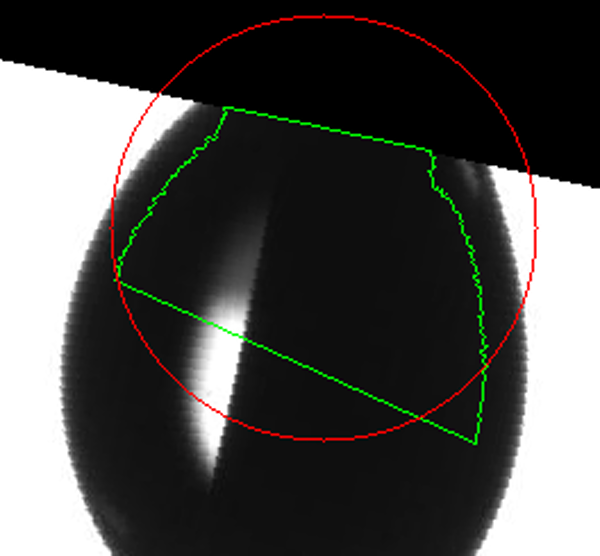

{'contact_angle(degrees)': 1.3973887659669455,
 'frame': 0,
 'height(mm)': 0.005424596749039169,
 'height_left(mm)': 0.8028403188577969,
 'height_right(mm)': 0.7648681416145228,
 'image_rotation(degrees)': 12.20911975849623,
 'pix/mm': 184.3455,
 'radius(mm)': 0.4448169334212118,
 'time': 0.0,
 'volume_left(uL)': 0.1476922488706906,
 'volume_right(uL)': 0.3765685051892874,
 'volume_sph_cap': 0.0016860540351089767}


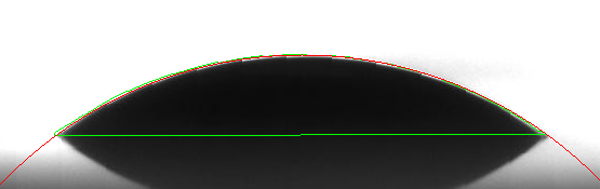

{'contact_angle(degrees)': 36.491709055156505,
 'frame': 1,
 'height(mm)': 0.40684475617793764,
 'height_left(mm)': 0.40684475617793764,
 'height_right(mm)': 0.40684475617793764,
 'image_rotation(degrees)': 1.3818670330297744,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 1.0,
 'volume_left(uL)': 1.0707217907104272,
 'volume_right(uL)': 0.9803523701629092,
 'volume_sph_cap': 1.0085592986094594}


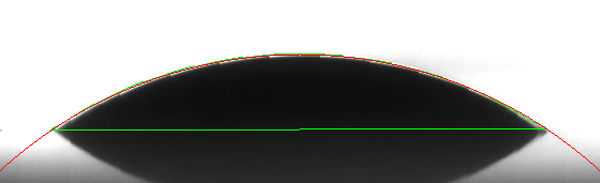

{'contact_angle(degrees)': 34.170595888974574,
 'frame': 2,
 'height(mm)': 0.38514636918178097,
 'height_left(mm)': 0.38514636918178097,
 'height_right(mm)': 0.38514636918178097,
 'image_rotation(degrees)': 1.2399747663125427,
 'pix/mm': 184.3455,
 'radius(mm)': 1.253081849028048,
 'time': 2.0,
 'volume_left(uL)': 0.9921299252267737,
 'volume_right(uL)': 0.9493798926927023,
 'volume_sph_cap': 0.9798724553128817}


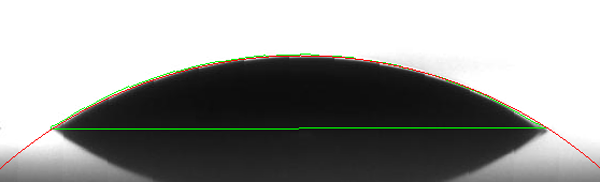

{'contact_angle(degrees)': 33.33006198784815,
 'frame': 3,
 'height(mm)': 0.37429717568370263,
 'height_left(mm)': 0.37429717568370263,
 'height_right(mm)': 0.3797217724327418,
 'image_rotation(degrees)': 1.366885038414664,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2503695506535284,
 'time': 3.0,
 'volume_left(uL)': 1.042528005177525,
 'volume_right(uL)': 0.9158861488752449,
 'volume_sph_cap': 0.9466634467645515}


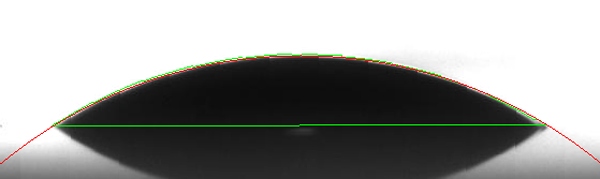

{'contact_angle(degrees)': 31.956441499060958,
 'frame': 4,
 'height(mm)': 0.35802338543658513,
 'height_left(mm)': 0.3634479821856243,
 'height_right(mm)': 0.3634479821856243,
 'image_rotation(degrees)': 1.2426636738447245,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2503695506535284,
 'time': 4.0,
 'volume_left(uL)': 0.929194884721502,
 'volume_right(uL)': 0.884041266109918,
 'volume_sph_cap': 0.9032700800996252}


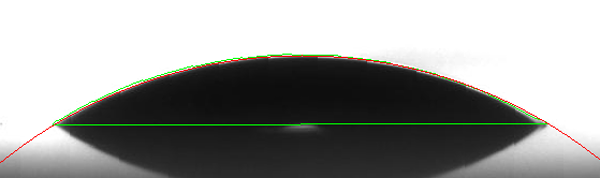

{'contact_angle(degrees)': 31.561506619030766,
 'frame': 5,
 'height(mm)': 0.35259878868754596,
 'height_left(mm)': 0.35802338543658513,
 'height_right(mm)': 0.35259878868754596,
 'image_rotation(degrees)': 1.245364266768613,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2476572522790088,
 'time': 5.0,
 'volume_left(uL)': 0.9508587525597137,
 'volume_right(uL)': 0.8649773967312395,
 'volume_sph_cap': 0.8851198626162918}


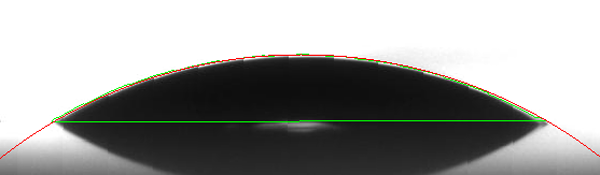

{'contact_angle(degrees)': 30.70027298484884,
 'frame': 6,
 'height(mm)': 0.3417495951894676,
 'height_left(mm)': 0.3417495951894676,
 'height_right(mm)': 0.3417495951894676,
 'image_rotation(degrees)': 1.3728386901467837,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2449449539044892,
 'time': 6.0,
 'volume_left(uL)': 0.9167007169923407,
 'volume_right(uL)': 0.8062380590248807,
 'volume_sph_cap': 0.8529081692800737}


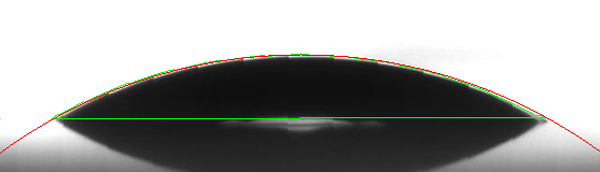

{'contact_angle(degrees)': 29.302717143644347,
 'frame': 7,
 'height(mm)': 0.3254758049423501,
 'height_left(mm)': 0.3254758049423501,
 'height_right(mm)': 0.3254758049423501,
 'image_rotation(degrees)': 1.3728386901467837,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2449449539044892,
 'time': 7.0,
 'volume_left(uL)': 0.8708100922596248,
 'volume_right(uL)': 0.7552407123596236,
 'volume_sph_cap': 0.8104430391746039}


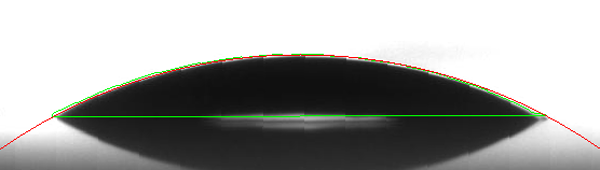

{'contact_angle(degrees)': 28.425437233558622,
 'frame': 8,
 'height(mm)': 0.3146266114442718,
 'height_left(mm)': 0.3146266114442718,
 'height_right(mm)': 0.3146266114442718,
 'image_rotation(degrees)': 1.5008560872932015,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2422326555299696,
 'time': 8.0,
 'volume_left(uL)': 0.8229409679919317,
 'volume_right(uL)': 0.7224787927196018,
 'volume_sph_cap': 0.7789502778413849}


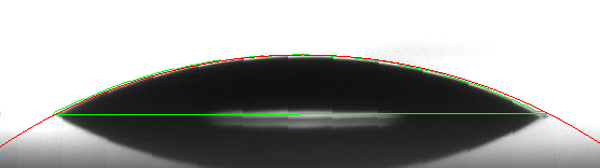

{'contact_angle(degrees)': 27.540880424187687,
 'frame': 9,
 'height(mm)': 0.30377741794619345,
 'height_left(mm)': 0.30377741794619345,
 'height_right(mm)': 0.30377741794619345,
 'image_rotation(degrees)': 1.3758350036636238,
 'pix/mm': 184.3455,
 'radius(mm)': 1.23952035715545,
 'time': 9.0,
 'volume_left(uL)': 0.8206318270172631,
 'volume_right(uL)': 0.7041221750756727,
 'volume_sph_cap': 0.7478108080565922}


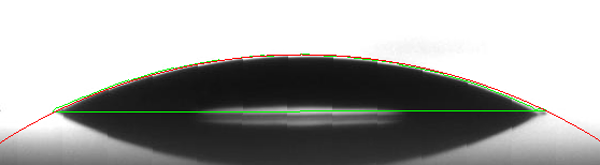

{'contact_angle(degrees)': 26.481039830374403,
 'frame': 10,
 'height(mm)': 0.2929282244481151,
 'height_left(mm)': 0.28750362769907595,
 'height_right(mm)': 0.2929282244481151,
 'image_rotation(degrees)': 1.3728386901467837,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2449449539044892,
 'time': 10.0,
 'volume_left(uL)': 0.7825771369500708,
 'volume_right(uL)': 0.715762157892386,
 'volume_sph_cap': 0.7263116340901985}


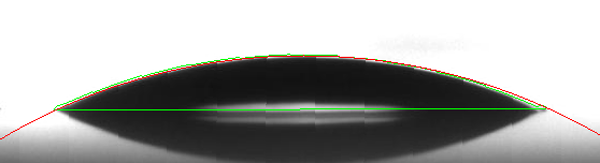

{'contact_angle(degrees)': 25.110593481577116,
 'frame': 11,
 'height(mm)': 0.2766544342009976,
 'height_left(mm)': 0.2820790309500368,
 'height_right(mm)': 0.2766544342009976,
 'image_rotation(degrees)': 1.250800814765407,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2422326555299696,
 'time': 11.0,
 'volume_left(uL)': 0.7718777604938947,
 'volume_right(uL)': 0.694444811643901,
 'volume_sph_cap': 0.6816866991051985}


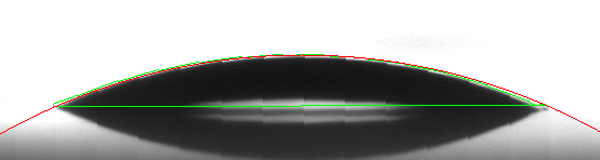

{'contact_angle(degrees)': 23.777316079255957,
 'frame': 12,
 'height(mm)': 0.2603806439538801,
 'height_left(mm)': 0.2603806439538801,
 'height_right(mm)': 0.2603806439538801,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 12.0,
 'volume_left(uL)': 0.71358858325118,
 'volume_right(uL)': 0.62140063478536,
 'volume_sph_cap': 0.6348957534451941}


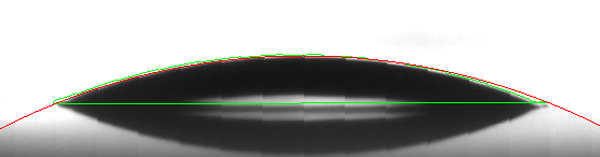

{'contact_angle(degrees)': 22.32976035509718,
 'frame': 13,
 'height(mm)': 0.24410685370676258,
 'height_left(mm)': 0.24953145045580175,
 'height_right(mm)': 0.24953145045580175,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 13.0,
 'volume_left(uL)': 0.697037789405524,
 'volume_right(uL)': 0.5923789083774368,
 'volume_sph_cap': 0.5941654252564559}


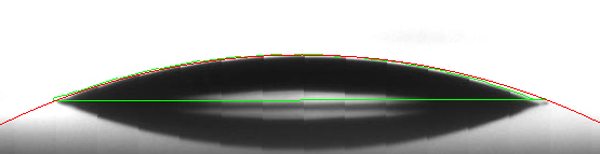

{'contact_angle(degrees)': 21.360667731219888,
 'frame': 14,
 'height(mm)': 0.23325766020868424,
 'height_left(mm)': 0.23325766020868424,
 'height_right(mm)': 0.23325766020868424,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 14.0,
 'volume_left(uL)': 0.6826558897358002,
 'volume_right(uL)': 0.5487698433061698,
 'volume_sph_cap': 0.5671255415729917}


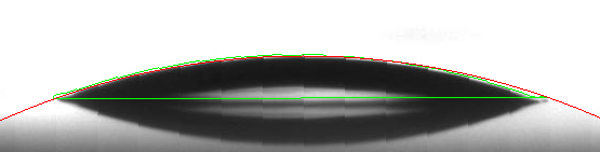

{'contact_angle(degrees)': 19.901253375903195,
 'frame': 15,
 'height(mm)': 0.21698386996156674,
 'height_left(mm)': 0.2224084667106059,
 'height_right(mm)': 0.2224084667106059,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 15.0,
 'volume_left(uL)': 0.655893992257698,
 'volume_right(uL)': 0.5219907284022395,
 'volume_sph_cap': 0.5267261891428929}


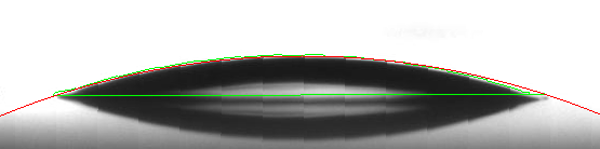

{'contact_angle(degrees)': 18.43528841987733,
 'frame': 16,
 'height(mm)': 0.20071007971444924,
 'height_left(mm)': 0.2061346764634884,
 'height_right(mm)': 0.2061346764634884,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 16.0,
 'volume_left(uL)': 0.5796010710207955,
 'volume_right(uL)': 0.47493884680322696,
 'volume_sph_cap': 0.4865073689447795}


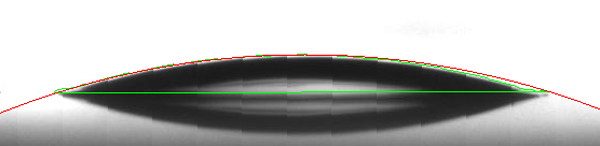

{'contact_angle(degrees)': 17.945253229792772,
 'frame': 17,
 'height(mm)': 0.19528548296541007,
 'height_left(mm)': 0.19528548296541007,
 'height_right(mm)': 0.19528548296541007,
 'image_rotation(degrees)': 1.378844422573564,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 17.0,
 'volume_left(uL)': 0.5502727741374458,
 'volume_right(uL)': 0.4535155214481879,
 'volume_sph_cap': 0.4731388735865459}


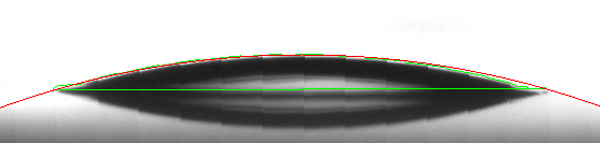

{'contact_angle(degrees)': 16.471238648419,
 'frame': 18,
 'height(mm)': 0.17901169271829256,
 'height_left(mm)': 0.17901169271829256,
 'height_right(mm)': 0.17901169271829256,
 'image_rotation(degrees)': 1.5041387292291462,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 18.0,
 'volume_left(uL)': 0.5067003169909979,
 'volume_right(uL)': 0.4092453406570125,
 'volume_sph_cap': 0.4331397009373475}


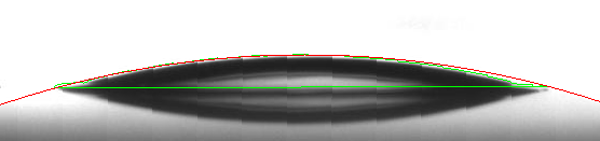

{'contact_angle(degrees)': 15.48547333527595,
 'frame': 19,
 'height(mm)': 0.16816249922021423,
 'height_left(mm)': 0.16816249922021423,
 'height_right(mm)': 0.16816249922021423,
 'image_rotation(degrees)': 1.378844422573564,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 19.0,
 'volume_left(uL)': 0.4817238498553336,
 'volume_right(uL)': 0.3854339750555483,
 'volume_sph_cap': 0.40655716557491206}


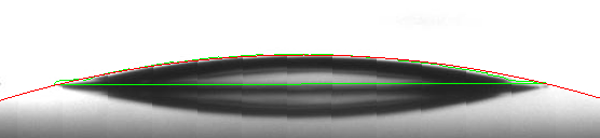

{'contact_angle(degrees)': 14.002535114990682,
 'frame': 20,
 'height(mm)': 0.15188870897309673,
 'height_left(mm)': 0.15188870897309673,
 'height_right(mm)': 0.15188870897309673,
 'image_rotation(degrees)': 1.378844422573564,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 20.0,
 'volume_left(uL)': 0.45073448927824705,
 'volume_right(uL)': 0.3565466448647697,
 'volume_sph_cap': 0.3667987025683605}


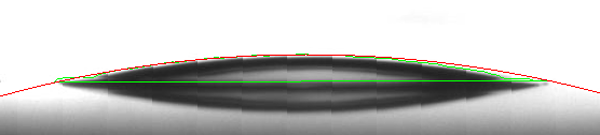

{'contact_angle(degrees)': 13.011253291367353,
 'frame': 21,
 'height(mm)': 0.1410395154750184,
 'height_left(mm)': 0.1410395154750184,
 'height_right(mm)': 0.1410395154750184,
 'image_rotation(degrees)': 1.378844422573564,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 21.0,
 'volume_left(uL)': 0.4079968265452563,
 'volume_right(uL)': 0.3140662405623577,
 'volume_sph_cap': 0.3403641033404684}


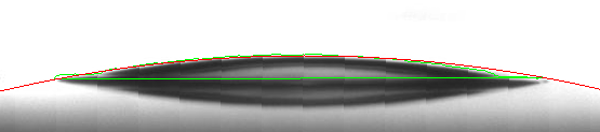

{'contact_angle(degrees)': 11.04703144759571,
 'frame': 22,
 'height(mm)': 0.1193411284788617,
 'height_left(mm)': 0.12476572522790087,
 'height_right(mm)': 0.12476572522790087,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 22.0,
 'volume_left(uL)': 0.38778674465294666,
 'volume_right(uL)': 0.3118881526153523,
 'volume_sph_cap': 0.28639102550785867}


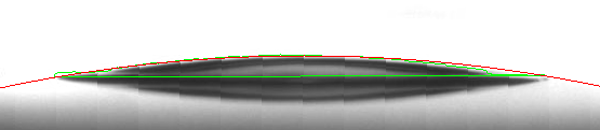

{'contact_angle(degrees)': 10.048150517079083,
 'frame': 23,
 'height(mm)': 0.10849193498078337,
 'height_left(mm)': 0.11391653172982254,
 'height_right(mm)': 0.10849193498078337,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 23.0,
 'volume_left(uL)': 0.35743676906414074,
 'volume_right(uL)': 0.23346712411418835,
 'volume_sph_cap': 0.26021506377620635}


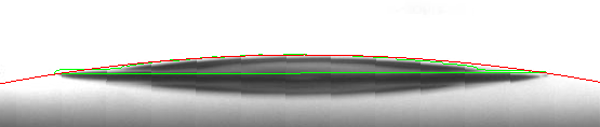

{'contact_angle(degrees)': 9.047736352355614,
 'frame': 24,
 'height(mm)': 0.09764274148270503,
 'height_left(mm)': 0.09764274148270503,
 'height_right(mm)': 0.09764274148270503,
 'image_rotation(degrees)': 1.3818670330297744,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 24.0,
 'volume_left(uL)': 0.26452150972668426,
 'volume_right(uL)': 0.21474108403258582,
 'volume_sph_cap': 0.23407922031832848}


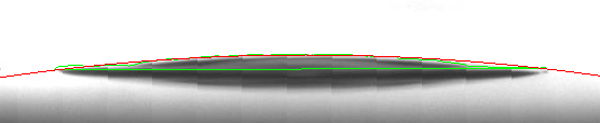

{'contact_angle(degrees)': 7.02750052120992,
 'frame': 25,
 'height(mm)': 0.07594435448654836,
 'height_left(mm)': 0.07594435448654836,
 'height_right(mm)': 0.07594435448654836,
 'image_rotation(degrees)': 1.378844422573564,
 'pix/mm': 184.3455,
 'radius(mm)': 1.2368080587809305,
 'time': 25.0,
 'volume_left(uL)': 0.2572057753444362,
 'volume_right(uL)': 0.17145530538415135,
 'volume_sph_cap': 0.18271132288894815}


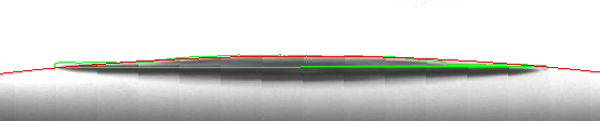

{'contact_angle(degrees)': 5.536378985863879,
 'frame': 26,
 'height(mm)': 0.05967056423943085,
 'height_left(mm)': 0.06509516098847003,
 'height_right(mm)': 0.05967056423943085,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 26.0,
 'volume_left(uL)': 0.2753577897921157,
 'volume_right(uL)': 0.16131758476081778,
 'volume_sph_cap': 0.142861778863968}


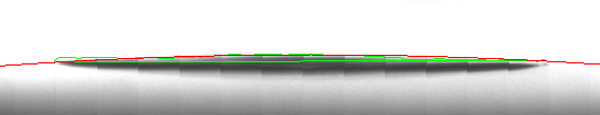

{'contact_angle(degrees)': 3.524782047321018,
 'frame': 27,
 'height(mm)': 0.03797217724327418,
 'height_left(mm)': 0.03797217724327418,
 'height_right(mm)': 0.03797217724327418,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 27.0,
 'volume_left(uL)': 0.20703085329155563,
 'volume_right(uL)': 0.18396251155228938,
 'volume_sph_cap': 0.09086991690778917}


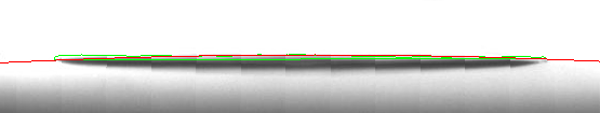

{'contact_angle(degrees)': 2.5180904143505276,
 'frame': 28,
 'height(mm)': 0.027122983745195842,
 'height_left(mm)': 0.027122983745195842,
 'height_right(mm)': 0.027122983745195842,
 'image_rotation(degrees)': 1.3818670330297744,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 28.0,
 'volume_left(uL)': 0.18494674653555626,
 'volume_right(uL)': 0.16044200343569007,
 'volume_sph_cap': 0.06489705393712007}


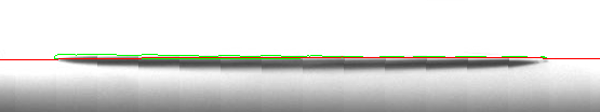

{'contact_angle(degrees)': 1.007372369934568,
 'frame': 29,
 'height(mm)': 0.010849193498078337,
 'height_left(mm)': 0.021698386996156675,
 'height_right(mm)': 0.016273790247117507,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 29.0,
 'volume_left(uL)': 0.18911052187492366,
 'volume_right(uL)': 0.1394225353699806,
 'volume_sph_cap': 0.025955311225892768}


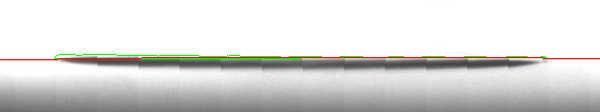

{'contact_angle(degrees)': 1.007372369934568,
 'frame': 30,
 'height(mm)': 0.010849193498078337,
 'height_left(mm)': 0.021698386996156675,
 'height_right(mm)': 0.010849193498078337,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 30.0,
 'volume_left(uL)': 0.18848267089035325,
 'volume_right(uL)': 0.14341998703265807,
 'volume_sph_cap': 0.025955311225892768}


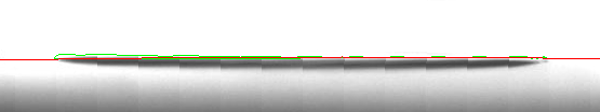

{'contact_angle(degrees)': 1.007372369934568,
 'frame': 31,
 'height(mm)': 0.010849193498078337,
 'height_left(mm)': 0.021698386996156675,
 'height_right(mm)': 0.010849193498078337,
 'image_rotation(degrees)': 1.5074357587748821,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 31.0,
 'volume_left(uL)': 0.1810474174841522,
 'volume_right(uL)': 0.24175656243283744,
 'volume_sph_cap': 0.025955311225892768}


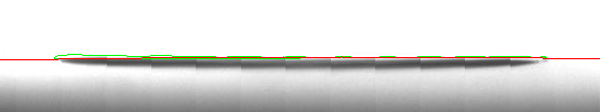

{'contact_angle(degrees)': 1.007372369934568,
 'frame': 32,
 'height(mm)': 0.010849193498078337,
 'height_left(mm)': 0.021698386996156675,
 'height_right(mm)': 0.010849193498078337,
 'image_rotation(degrees)': 1.3818670330297744,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 32.0,
 'volume_left(uL)': 0.15631851352957116,
 'volume_right(uL)': 0.1367433033197425,
 'volume_sph_cap': 0.025955311225892768}


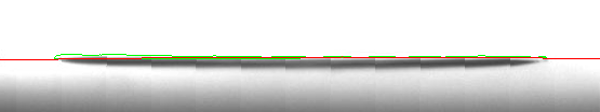

{'contact_angle(degrees)': 1.007372369934568,
 'frame': 33,
 'height(mm)': 0.010849193498078337,
 'height_left(mm)': 0.021698386996156675,
 'height_right(mm)': 0.016273790247117507,
 'image_rotation(degrees)': 1.3818670330297744,
 'pix/mm': 184.3455,
 'radius(mm)': 1.234095760406411,
 'time': 33.0,
 'volume_left(uL)': 0.20045162355201723,
 'volume_right(uL)': 0.13152090703115135,
 'volume_sph_cap': 0.025955311225892768}


In [ ]:
import csv

# Set this to False in order to stop showing images.
SHOW_IMAGES = True
# Set to true to process one every 10 frames
SKIP_FRAMES = False
if RUN_VIDEO:
  for video_path in VIDEO_PATHS:
    csv_path = video_path + ".csv"
    with open(csv_path, 'w')  as output_file:
      written_header = False
      print("##### VIDEO: %s #####" % video_path)
      for i,(t,f) in enumerate(video_frames(video_path)):
        if i % ONE_FRAME_EVERY != 0: continue
        droplet = Droplet(f)
        report = droplet.report()
        report["time"] = t
        report["frame"] = i
        if SHOW_IMAGES:
          droplet.show()
        l,r = droplet.halves()
        report.update(l.report())
        report.update(r.report())
        pp(report)
        if not written_header:
          keys = ["frames","time"] + [k for k in report.keys() if k not in ["frames","time"]]
          dict_writer = csv.DictWriter(output_file, keys)
          dict_writer.writeheader()
          written_header = True

        dict_writer.writerow(report)